In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Homosexual relationship

In [2]:
import os, json, numpy as np, pandas as pd, torch, torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import math
import matplotlib.pyplot as plt

# Set up paths
BASE_MODEL_NAME = "meta-llama/llama-3.1-8b"    # or mistral
SAVE_DIR   = "/content/drive/MyDrive/LLM_POC_Study_2025_v2/outputs_gss_p_trial/final_multitask_homosex_g4"  # from training step
HEAD_PATH  = os.path.join(SAVE_DIR, "two_head_homosex_g4.pt")

ABORT4 = ["strong_anti", "anti", "pro", "strong_pro"]
TRUST3 = ["distrust", "depends", "trust"]
ENVIR3 = ["too_little", "about_right", "too_much"]
HOMOSEX4 = ["always_wrong", "almost_always_wrong", "sometimes_wrong", "not_wrong_at_all"]

GROUP_COLS_4 = ["generation","gender","race","edu_level"]
GROUP_COLS_3 = ["generation","gender","race"]
GROUP_COLS_2 = ["generation","gender"]
GROUP_COLS_1 = ["generation"]

# Homosexuality (K=4)
K = len(HOMOSEX4)

# Load tokenizer + base + LoRA
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    output_hidden_states=True
)
model = PeftModel.from_pretrained(base, SAVE_DIR)
model.eval()

# Two-head module (must match training)
import torch.nn as nn
class TwoHead(nn.Module):
    def __init__(self, hidden_size, K):
        super().__init__()
        self.head_row    = nn.Linear(hidden_size, K)   # Task A
        self.head_margin = nn.Linear(hidden_size, K)   # Task B
    def forward(self, feats):
        return self.head_row(feats), self.head_margin(feats)

hidden_size = base.config.hidden_size
two_head = TwoHead(hidden_size, K).to(model.device)
two_head.load_state_dict(torch.load(HEAD_PATH, map_location=model.device))
two_head.eval()

def pooled_features(outputs, attention_mask, tail=96):
    hs = outputs.hidden_states[-1]   # [B,T,H]
    valid = attention_mask.sum(dim=1)
    feats = []
    for b in range(hs.size(0)):
        L = int(valid[b].item())
        s = max(0, L - tail); e = L
        if e <= s: s, e = max(0, L-32), L
        feats.append(hs[b, s:e, :].mean(dim=0))
    return torch.stack(feats, dim=0)


config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [3]:
# Helpers: predict a row/margin/full matrix
def _to_head_dtype(x):
    return x.to(two_head.head_row.weight.dtype)

@torch.no_grad()
def predict_row_distribution(group, year_t, year_t1, from_bin, dt=None, max_len=768):
    """Task A: one row (from_bin) of the transition matrix."""
    if dt is None: dt = int(year_t1) - int(year_t)
    prompt = (
        "[Task: Predict transition row]\n"
        f"From: <Y{year_t}> → To: <Y{year_t1}> <DT{dt}>\n"
        f"Group: generation={group['generation']}; gender={group['gender']}; race={group['race']}; edu_level={group['edu_level']}\n"
        f"From option: {from_bin}\n"
        "Answer:\n"
    )
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_len)
    ids = enc["input_ids"].to(model.device); attn = enc["attention_mask"].to(model.device)
    with torch.cuda.amp.autocast(dtype=torch.bfloat16):
        out = model(input_ids=ids, attention_mask=attn, output_hidden_states=True)
    feats = pooled_features(out, attn, tail=96).to(model.device)
    feats = _to_head_dtype(feats)
    logits_row, _ = two_head(feats)
    p = F.softmax(logits_row, dim=1).float().cpu().numpy()[0]
    return p  # shape [K]

@torch.no_grad()
def predict_full_transition(group, year_t, year_t1, max_len=768):
    """Assemble 4×4 by calling row head for each from-bin."""
    T = np.zeros((K,K), dtype=np.float32)
    dt = int(year_t1) - int(year_t)
    for i, from_bin in enumerate(HOMOSEX4):
        T[i,:] = predict_row_distribution(group, year_t, year_t1, from_bin, dt=dt, max_len=max_len)
    # force row-stochastic
    T = np.clip(T, 1e-12, 1)
    T = T / T.sum(axis=1, keepdims=True)
    return T

@torch.no_grad()
def predict_next_margin(group, context, target_year, max_len=768):
    """
    Task B: context = list of (year, prob_vector length K) tuples.
    """
    ctx_parts = " ".join([f"<Y{yy}>[{','.join(f'{x:.4f}' for x in p)}]" for (yy,p) in context])
    prompt = (
        "[Task: Forecast next-wave margin]\n"
        f"Group: generation={group['generation']}; gender={group['gender']}; race={group['race']}; edu_level={group['edu_level']}\n"
        f"Context: {ctx_parts}\n"
        f"Predict: <Y{target_year}>\n"
        "Answer:\n"
    )
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_len)
    ids = enc["input_ids"].to(model.device); attn = enc["attention_mask"].to(model.device)
    with torch.cuda.amp.autocast(dtype=torch.bfloat16):
        out = model(input_ids=ids, attention_mask=attn, output_hidden_states=True)
    feats = pooled_features(out, attn, tail=96).to(model.device)
    feats = _to_head_dtype(feats)
    _, logits_margin = two_head(feats)
    p = F.softmax(logits_margin, dim=1).float().cpu().numpy()[0]
    return p


In [4]:
# Using real margins and forecasting
# Load cross-sectional CSV and build p_cs[(g,y)]
cs = pd.read_csv("/content/drive/MyDrive/LLM_POC_Study_2025_v2/gss_abt_cs_homosex.csv")
# Map to 4 bins if numeric:
# def map_att(v):
#     if isinstance(v, (int, np.integer, float)) and not pd.isna(v):
#         return {1:"strong_anti",2:"anti",3:"pro",4:"strong_pro"}.get(int(v), None)
#     return str(v).strip()
# cs["trust"] = cs["abortion_att4"].apply(map_att)
cs = cs[cs["homosex"].isin(HOMOSEX4)].copy()
cs["wt"] = cs.get("wtssps", pd.Series([1.0]*len(cs)))

GROUP_COLS = GROUP_COLS_4
for c in GROUP_COLS: cs[c] = cs[c].astype(str).str.strip()

def weighted_probs(vals, wts):
    d = {c:0.0 for c in HOMOSEX4}
    for v,w in zip(vals,wts): d[v]+=float(w)
    vec = np.array([d[c] for c in HOMOSEX4],dtype=float)
    s = vec.sum()
    return vec/s if s>0 else None

p_cs = {}
for (gvals, df_g) in cs.groupby(GROUP_COLS):
    for y, df_y in df_g.groupby("year"):
        p = weighted_probs(df_y["homosex"].tolist(), df_y["wt"].tolist())
        if p is not None:
            p_cs[(gvals, int(y))] = p


In [5]:
def forecast_every_year_from_previous(
    p_cs,                       # dict: {(gen,gender,race, edu_level), year} -> np.array length 5 (observed)
    alpha=0.5,                  # ensemble weight: alpha*transition + (1-alpha)*margin
    save_csv_path=None,         # optional: path to save tidy CSV
    context_lags=(4, 2, 0),     # try up to these lags relative to y_prev (0 means include y_prev itself)
    max_len=768,                # tokenizer max length
):
    """
    Produce forecasts for every (group, year) using the immediately previous observed year as the anchor.
    Returns:
        p_hat: dict keyed by ((gen,gender,race), year) -> np.array([4]) forecast for that year
        df_out: tidy DataFrame with observed (if available) and all forecast variants
    """
    # collect groups and years present in observed margins
    all_pairs = list(p_cs.keys())
    groups = sorted({g for (g, y) in all_pairs})
    years_by_g = {g: sorted([y for (gg, y) in all_pairs if gg == g]) for g in groups}

    rows = []
    p_hat = {}

    for g in groups:
        ys = years_by_g[g]
        if not ys:
            continue
        for idx in range(1, len(ys)):  # start from the second observed year
            y_prev = ys[idx - 1]
            y = ys[idx]

            # observed previous margin
            p_prev = p_cs.get((g, y_prev), None)
            if p_prev is None:
                continue  # cannot forecast without previous anchor

            # build context relative to y_prev (e.g., y_prev-4, y_prev-2, y_prev)
            ctx = []
            for L in context_lags:
                y_ctx = y_prev - L
                if (g, y_ctx) in p_cs:
                    ctx.append((y_ctx, p_cs[(g, y_ctx)]))
            # ensure the last element of context is the anchor y_prev if available
            if len(ctx) == 0 and (g, y_prev) in p_cs:
                ctx.append((y_prev, p_cs[(g, y_prev)]))

            # group dict for prompt
            group = {"generation": g[0], "gender": g[1], "race": g[2], "edu_level": g[3]}

            # predict transition matrix for the exact gap (usually 2; could be 4)
            T = predict_full_transition(group, y_prev, y, max_len=max_len)  # shape [4,4]
            p_trans = (p_prev @ T)  # transition-propagated forecast

            # predict margin directly (if context exists)
            if len(ctx) > 0:
                p_margin = predict_next_margin(group, ctx, y, max_len=max_len)
            else:
                p_margin = p_trans.copy()  # fallback

            # ensemble
            p_mix = alpha * p_trans + (1 - alpha) * p_margin
            p_mix = np.clip(p_mix, 1e-12, 1.0)
            p_mix = p_mix / p_mix.sum()

            p_hat[(g, y)] = p_mix

            # observed for target (if available)
            p_obs = p_cs.get((g, y), None)

            # metrics (if observed exists)
            def jsd(p, q, eps=1e-9):
                p = np.clip(p, eps, 1); q = np.clip(q, eps, 1)
                p /= p.sum(); q /= q.sum(); m = 0.5*(p+q)
                return 0.5*np.sum(p*np.log(p/m)) + 0.5*np.sum(q*np.log(q/m))
            def rmse(p, q): return float(np.sqrt(np.mean((p-q)**2)))

            rec = {
                "generation": g[0], "gender": g[1], "race": g[2], "edu_level": g[3],
                "year_prev": y_prev, "year": y,
                **{f"p_prev_{c}": float(p_prev[i]) for i, c in enumerate(HOMOSEX4)},
                **{f"p_trans_{c}": float(p_trans[i]) for i, c in enumerate(HOMOSEX4)},
                **{f"p_margin_{c}": float(p_margin[i]) for i, c in enumerate(HOMOSEX4)},
                **{f"p_hat_{c}": float(p_mix[i]) for i, c in enumerate(HOMOSEX4)},
            }
            if p_obs is not None:
                rec.update({f"p_obs_{c}": float(p_obs[i]) for i, c in enumerate(HOMOSEX4)})
                rec["JSD_hat_vs_obs"] = float(jsd(p_mix, p_obs))
                rec["RMSE_hat_vs_obs"] = rmse(p_mix, p_obs)
                rec["JSD_trans_vs_obs"] = float(jsd(p_trans, p_obs))
                rec["JSD_margin_vs_obs"] = float(jsd(p_margin, p_obs))
            rows.append(rec)

    df_out = pd.DataFrame(rows)
    if save_csv_path:
        df_out.to_csv(save_csv_path, index=False)
    return p_hat, df_out

In [6]:
# Run (save a long tidy CSV)
p_hat, df_prev = forecast_every_year_from_previous(
    p_cs,
    alpha=0.5,
    save_csv_path="/content/drive/MyDrive/LLM_POC_Study_2025_v2/p_trial_results/forecasts_from_previous_year_homosex_g4.csv"
)

# Read p_hat directly:
GEN, GENDER, RACE, EDU_LEVEL = "Millennial", "Female", "White", "Associate or Bachelor's Degree"
years = sorted({y for ((g,y),_) in p_hat.items() if g==(GEN,GENDER,RACE,EDU_LEVEL)})

/tmp/ipython-input-3491668918.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tmp/ipython-input-3491668918.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):


In [7]:
def backtest_interval(year_t, year_t1, alpha=0.5):
    results = []
    groups = sorted({g for (g,y) in p_cs.keys() if y==year_t})
    for g in groups:
        if (g,year_t) not in p_cs or (g,year_t1) not in p_cs:
            continue
        group = {"generation": g[0], "gender": g[1], "race": g[2], "edu_level": g[3]}
        p_t = p_cs[(g,year_t)]
        # context: use up to two previous margins if present
        ctx_years = [year_t-4, year_t-2, year_t]
        ctx = [(yy, p_cs[(g,yy)]) for yy in ctx_years if (g,yy) in p_cs]
        T = predict_full_transition(group, year_t, year_t1)
        p_next_trans = p_t @ T
        p_next_margin = predict_next_margin(group, ctx, year_t1) if len(ctx)>0 else p_next_trans
        p_hat = alpha*p_next_trans + (1-alpha)*p_next_margin
        p_obs = p_cs[(g,year_t1)]
        def jsd(p,q,eps=1e-9):
            p = np.clip(p,eps,1); q = np.clip(q,eps,1)
            p/=p.sum(); q/=q.sum(); m=0.5*(p+q)
            return 0.5*np.sum(p*np.log(p/m)) + 0.5*np.sum(q*np.log(q/m))
        def rmse(p,q): return float(np.sqrt(np.mean((p-q)**2)))
        results.append({
            "year_t": year_t, "year_t1": year_t1,
            "generation": g[0], "gender": g[1], "race": g[2], "edu_level": g[3],
            "JSD_hat": float(jsd(p_hat, p_obs)),
            "JSD_trans": float(jsd(p_next_trans, p_obs)),
            "JSD_margin": float(jsd(p_next_margin, p_obs)),
            "RMSE_hat": float(rmse(p_hat, p_obs)),
        })
    return pd.DataFrame(results)

bt_all = []
for y0 in range(2008, 2024, 2):  # 2008→2010 … 2022→2024
    bt_all.append(backtest_interval(y0, y0+2, alpha=0.5))
bt = pd.concat(bt_all, ignore_index=True)
bt_out = os.path.join(SAVE_DIR, "/content/drive/MyDrive/LLM_POC_Study_2025_v2/p_trial_results/backtest_by_interval_homosex_g4.csv")
bt.to_csv(bt_out, index=False)
bt_out, bt.groupby(["year_t","year_t1"]).JSD_hat.mean()

/tmp/ipython-input-3491668918.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tmp/ipython-input-3491668918.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tmp/ipython-input-3491668918.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tmp/ipython-input-3491668918.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):


('/content/drive/MyDrive/LLM_POC_Study_2025_v2/p_trial_results/backtest_by_interval_homosex_g4.csv',
 year_t  year_t1
 2008    2010       0.080135
 2010    2012       0.086645
 2012    2014       0.072485
 2014    2016       0.077143
 2016    2018       0.081730
 2022    2024       0.091100
 Name: JSD_hat, dtype: float64)

# Visualization

In [8]:
# Set up paths
CS_CSV    = "/content/drive/MyDrive/LLM_POC_Study_2025_v2/gss_abt_cs_homosex.csv"       # cross-sectional long
PANEL_CSV = "/content/drive/MyDrive/LLM_POC_Study_2025_v2/gss_abt_panel_homosex.csv"    # panel long
OUT_DIR   = "/content/drive/MyDrive/LLM_POC_Study_2025_v2/outputs_gss_p_trial"          # where I write JSONLs & checkpoints
os.makedirs(OUT_DIR, exist_ok=True)

# LLM choice
BASE_MODEL_NAME = "meta-llama/llama-3.1-8b"  # or "mistralai/Mistral-7B-v0.3"

# Canonical bins (K=4)
ABORT4 = ["strong_anti", "anti", "pro", "strong_pro"]
TRUST3 = ["distrust", "depends", "trust"]
ENVIR3 = ["too_little", "about_right", "too_much"]
HOMOSEX4 = ["always_wrong", "almost_always_wrong", "sometimes_wrong", "not_wrong_at_all"]
ABORT2ID = {c:i for i,c in enumerate(ABORT4)}
TRUST2ID = {c:i for i,c in enumerate(TRUST3)}
ENVIR2ID = {c:i for i,c in enumerate(ENVIR3)}
HOMOSEX2ID = {c:i for i,c in enumerate(HOMOSEX4)}

K = len(HOMOSEX4)
YEARS_CS = list(range(2006, 2025, 2))  # 2006..2024 every 2 years

# Load and harmonize the data
# --- Cross-sectional ---
cs = pd.read_csv(CS_CSV)
# Expect: yearid, year, abortion_att4, generation, race, gender, edu_level, wtssps
# Map the attitude to canonical
# cs["att"] = cs["abortion_att4"].astype(str).str.strip()

# keep only canon categories, drop NAs
cs = cs[cs["homosex"].isin(HOMOSEX4)].copy()
cs["wt"] = cs.get("wtssps", pd.Series([1.0]*len(cs)))  # default 1.0 if missing

# --- Panel ---
pl = pd.read_csv(PANEL_CSV)
# Expect: id, year, abortion_att4, generation, race, gender, edu_level
pl["homosex"] = pl["homosex"].astype(str).str.strip()
pl = pl[pl["homosex"].isin(HOMOSEX4)].copy()

# Define grouping keys
GROUP_COLS = ["generation","gender","race","edu_level"]
for df in (cs, pl):
    for c in GROUP_COLS:
        df[c] = df[c].astype(str).str.strip()

# Build cross-section margins p_cs[g,y] (weighted)
def group_key(row):
    return (row["generation"], row["gender"], row["race"], row['edu_level'])

def weighted_probs(vals, wts, cats=HOMOSEX4):
    # vals: list of category strings; wts: weights
    counts = {c:0.0 for c in cats}
    for v, w in zip(vals, wts):
        counts[v] += float(w)
    vec = np.array([counts[c] for c in cats], dtype=float)
    s = vec.sum()
    if s <= 0: return None
    return vec / s

# p_cs[(g,y)] -> np.array[K]
p_cs = {}
effN_cs = {}  # effective N for weighting samples in Task B
for y in YEARS_CS:
    sub = cs[cs["year"]==y]
    if sub.empty:
        continue
    for g_vals, df_g in sub.groupby(GROUP_COLS):
        p = weighted_probs(df_g["homosex"].tolist(), df_g["wt"].tolist(), HOMOSEX4)
        if p is None:
            continue
        p_cs[(g_vals, y)] = p
        effN_cs[(g_vals, y)] = float(df_g["wt"].sum())

In [11]:
def dirichlet_sample(p, alpha_eff, n_samp=1):
    # Safe-guard: tiny floor so alphas > 0
    p = np.clip(np.array(p, dtype=float), 1e-12, 1.0)
    p = p / p.sum()
    a = np.maximum(alpha_eff * p, 1e-6)
    return np.random.dirichlet(a, size=n_samp)  # [n_samp, K]

def forecast_with_bands_for_group(
    g, years, p_cs, effN_cs, alpha=0.5, B=400, context_lags=(4,2,0), max_len=768
):
    """
    For subgroup g = (generation, gender, race, edu_level) and an ordered list of 'years',
    compute forecast mean + 95% bands (from previous observed year),
    and observed bands via Dirichlet sampling.

    Returns:
      dict with:
        obs_mean[year], obs_lo[year], obs_hi[year] -> arrays length K (or None if year missing)
        hat_mean[year], hat_lo[year], hat_hi[year] -> arrays length K for forecast years (y>y_prev)
    """
    out = {
        "obs_mean": {}, "obs_lo": {}, "obs_hi": {},
        "hat_mean": {}, "hat_lo": {}, "hat_hi": {}
    }

    # Observed bands for all available years
    for y in years:
        p = p_cs.get((g, y), None)
        if p is None:
            out["obs_mean"][y] = out["obs_lo"][y] = out["obs_hi"][y] = None
            continue
        alpha_eff = float(effN_cs.get((g,y), 200.0))  # fallback effN if missing
        samp = dirichlet_sample(p, alpha_eff, n_samp=B)  # [B,K]
        out["obs_mean"][y] = np.mean(samp, axis=0)
        out["obs_lo"][y]   = np.quantile(samp, 0.025, axis=0)
        out["obs_hi"][y]   = np.quantile(samp, 0.975, axis=0)

    # Forecast bands for each step using the immediately previous observed year
    # years should already be sorted
    for i in range(1, len(years)):
        y_prev, y = years[i-1], years[i]
        p_prev = p_cs.get((g, y_prev), None)
        if p_prev is None:
            continue

        # Build context list for the margin head (sampled each bootstrap)
        ctx_years = [y_prev - L for L in context_lags]
        # Precompute transition matrix once (keep fixed across bootstraps)
        group = {"generation": g[0], "gender": g[1], "race": g[2], "edu_level": g[3]}
        T = predict_full_transition(group, y_prev, y, max_len=max_len)  # [K,K]

        samp_mix = np.zeros((B, len(HOMOSEX4)), dtype=float)
        for b in range(B):
            # Sample anchor previous margin
            alpha_prev = float(effN_cs.get((g, y_prev), 200.0))
            p_prev_b = dirichlet_sample(p_prev, alpha_prev, n_samp=1)[0]  # [K]

            # Sample context margins
            ctx = []
            for yy in ctx_years:
                if (g, yy) in p_cs:
                    alpha_ctx = float(effN_cs.get((g, yy), 200.0))
                    p_ctx_b = dirichlet_sample(p_cs[(g, yy)], alpha_ctx, n_samp=1)[0]
                    ctx.append((yy, p_ctx_b))
            if len(ctx) == 0:
                # at least include the sampled previous margin as context if nothing else
                ctx.append((y_prev, p_prev_b))

            # Propagate via transition head (T fixed)
            p_trans_b = p_prev_b @ T

            # Margin head with sampled context
            p_margin_b = predict_next_margin(group, ctx, y, max_len=max_len)

            # Ensemble
            p_mix_b = alpha * p_trans_b + (1 - alpha) * p_margin_b
            p_mix_b = np.clip(p_mix_b, 1e-12, 1.0); p_mix_b /= p_mix_b.sum()
            samp_mix[b, :] = p_mix_b

        out["hat_mean"][y] = np.mean(samp_mix, axis=0)
        out["hat_lo"][y]   = np.quantile(samp_mix, 0.025, axis=0)
        out["hat_hi"][y]   = np.quantile(samp_mix, 0.975, axis=0)

    return out

def plot_obs_vs_forecast_with_bands(g, years, bands_dict, title_suffix=""):
    CATS = HOMOSEX4
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
    axes = axes.ravel()

    for k, cat in enumerate(CATS):
        ax = axes[k]

        # Observed mean + band
        ys_obs = []; obs_m = []; obs_lo = []; obs_hi = []
        for y in years:
            m = bands_dict["obs_mean"].get(y)
            l = bands_dict["obs_lo"].get(y)
            h = bands_dict["obs_hi"].get(y)
            if m is None:
                ys_obs.append(y); obs_m.append(np.nan); obs_lo.append(np.nan); obs_hi.append(np.nan)
            else:
                ys_obs.append(y); obs_m.append(m[k]); obs_lo.append(l[k]); obs_hi.append(h[k])

        # Forecast mean + band (exists only for y>y_prev)
        ys_hat = []; hat_m = []; hat_lo = []; hat_hi = []
        for i in range(1, len(years)):
            y = years[i]
            if y in bands_dict["hat_mean"]:
                ys_hat.append(y)
                hat_m.append(bands_dict["hat_mean"][y][k])
                hat_lo.append(bands_dict["hat_lo"][y][k])
                hat_hi.append(bands_dict["hat_hi"][y][k])

        # Observed (solid) + band
        ax.plot(ys_obs, obs_m, marker="o", color="#1984c5", label="Observed", zorder=3)
        ax.fill_between(ys_obs, obs_lo, obs_hi, color="#1984c5", alpha=0.15, label="Observed 95% CI", zorder=1)

        # Forecast (dashed) + band
        if len(ys_hat):
            ax.plot(ys_hat, hat_m, marker="s", color="#e14b31", linestyle="--", label="Forecast", zorder=3)
            ax.fill_between(ys_hat, hat_lo, hat_hi, color="#e14b31", alpha=0.15, label="Forecast 95% CI", zorder=1)

        ax.set_ylim(0,0.85)
        ax.set_xticks(range(2006,2026,2))
        ax.set_title(cat)
        if (k==0) or (k==2): ax.set_ylabel("Share")
        if k >= 2: ax.set_xlabel("Year")
        ax.grid(alpha=0.3)
        if k == 0:
            ax.legend(frameon=False)

    gen, gender, race, edu_level = g
    #fig.suptitle(f"Observed vs Forecast with 95% Bands — {gen}, {gender}, {race}, {edu_level} {title_suffix}")
    plt.tight_layout(); plt.show()


/tmp/ipython-input-3491668918.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tmp/ipython-input-3491668918.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):


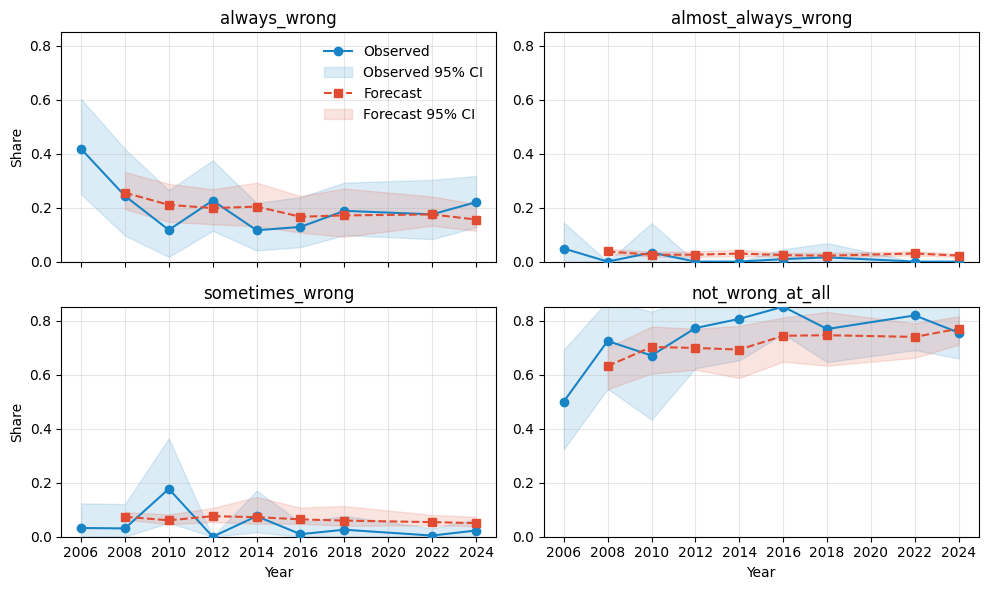

In [12]:
import matplotlib.pyplot as plt

# Pick a subgroup & its years (years where you have observed margins)
GEN, GENDER, RACE, EDU_LEVEL = "Millennial", "Female", "White", "Associate or Bachelor's Degree"
g = (GEN, GENDER, RACE, EDU_LEVEL)
years = sorted({y for ((gg,y),_) in p_cs.items() if gg==g})

bands = forecast_with_bands_for_group(
    g, years, p_cs, effN_cs,
    alpha=0.5,   # ensemble weight
    B=300        # bootstrap size (200–1000 is typical)
)
plot_obs_vs_forecast_with_bands(g, years, bands)

/tmp/ipython-input-3541918774.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tmp/ipython-input-3541918774.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):


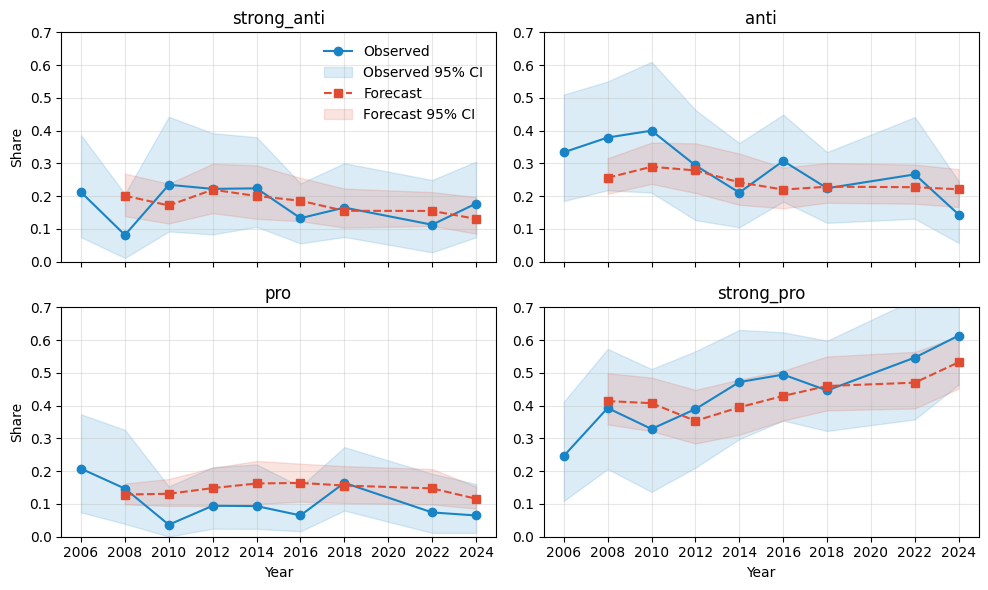

In [ ]:
import matplotlib.pyplot as plt

# Pick a subgroup & its years (years where you have observed margins)
GEN, GENDER, RACE, EDU_LEVEL = "Millennial", "Female", "White", "Associate or Bachelor's Degree"
g = (GEN, GENDER, RACE, EDU_LEVEL)
years = sorted({y for ((gg,y),_) in p_cs.items() if gg==g})

bands = forecast_with_bands_for_group(
    g, years, p_cs, effN_cs,
    alpha=0.5,   # ensemble weight
    B=300        # bootstrap size (200–1000 is typical)
)
plot_obs_vs_forecast_with_bands(g, years, bands)

/tmp/ipython-input-4128035234.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=systems, showfliers=False)


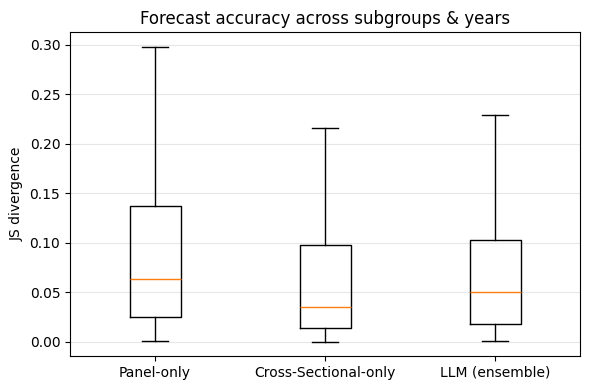

In [13]:
# Build a long df with three systems: No-change, Panel-only, LLM (hat) — per (g, interval)
df_cmp = bt.copy()  # has JSD_hat, JSD_trans; compute No-change JSD if you saved it; else omit
rows = []
for _, r in df_cmp.iterrows():
    rows.append({"system":"Panel-only", "JSD": r["JSD_trans"], "year_t": r["year_t"], "year_t1": r["year_t1"]})
    rows.append({"system":"Cross-Sectional-only", "JSD": r["JSD_margin"], "year_t": r["year_t"], "year_t1": r["year_t1"]})
    rows.append({"system":"LLM (ensemble)", "JSD": r["JSD_hat"], "year_t": r["year_t"], "year_t1": r["year_t1"]})
cmp_long = pd.DataFrame(rows)

fig, ax = plt.subplots(figsize=(6,4))
systems = cmp_long["system"].unique()
data = [cmp_long[cmp_long["system"]==s]["JSD"].dropna().values for s in systems]
ax.boxplot(data, labels=systems, showfliers=False)
ax.set_ylabel("JS divergence")
ax.set_title("Forecast accuracy across subgroups & years")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()


### Homosex Group 3

In [14]:
import os, json, numpy as np, pandas as pd, torch, torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import math

# Set up paths
BASE_MODEL_NAME = "meta-llama/llama-3.1-8b"    # or mistral
SAVE_DIR   = "/content/drive/MyDrive/LLM_POC_Study_2025_v2/outputs_gss_p_trial/final_multitask_homosex_g3"  # from training step
HEAD_PATH  = os.path.join(SAVE_DIR, "two_head_homosex_g3.pt")

ABORT4 = ["strong_anti", "anti", "pro", "strong_pro"]
TRUST3 = ["distrust", "depends", "trust"]
ENVIR3 = ["too_little", "about_right", "too_much"]
HOMOSEX4 = ["always_wrong", "almost_always_wrong", "sometimes_wrong", "not_wrong_at_all"]

GROUP_COLS_4 = ["generation","gender","race","edu_level"]
GROUP_COLS_3 = ["generation","gender","race"]
GROUP_COLS_2 = ["generation","gender"]
GROUP_COLS_1 = ["generation"]

# Homosexuality (K=4)
K = len(HOMOSEX4)

# Load tokenizer + base + LoRA
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    output_hidden_states=True
)
model = PeftModel.from_pretrained(base, SAVE_DIR)
model.eval()

# Two-head module (must match training)
import torch.nn as nn
class TwoHead(nn.Module):
    def __init__(self, hidden_size, K):
        super().__init__()
        self.head_row    = nn.Linear(hidden_size, K)   # Task A
        self.head_margin = nn.Linear(hidden_size, K)   # Task B
    def forward(self, feats):
        return self.head_row(feats), self.head_margin(feats)

hidden_size = base.config.hidden_size
two_head = TwoHead(hidden_size, K).to(model.device)
two_head.load_state_dict(torch.load(HEAD_PATH, map_location=model.device))
two_head.eval()

def pooled_features(outputs, attention_mask, tail=96):
    hs = outputs.hidden_states[-1]   # [B,T,H]
    valid = attention_mask.sum(dim=1)
    feats = []
    for b in range(hs.size(0)):
        L = int(valid[b].item())
        s = max(0, L - tail); e = L
        if e <= s: s, e = max(0, L-32), L
        feats.append(hs[b, s:e, :].mean(dim=0))
    return torch.stack(feats, dim=0)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
# Helpers: predict a row/margin/full matrix
def _to_head_dtype(x):
    return x.to(two_head.head_row.weight.dtype)

@torch.no_grad()
def predict_row_distribution(group, year_t, year_t1, from_bin, dt=None, max_len=768):
    """Task A: one row (from_bin) of the transition matrix."""
    if dt is None: dt = int(year_t1) - int(year_t)
    prompt = (
        "[Task: Predict transition row]\n"
        f"From: <Y{year_t}> → To: <Y{year_t1}> <DT{dt}>\n"
        f"Group: generation={group['generation']}; gender={group['gender']}; race={group['race']}\n"
        f"From option: {from_bin}\n"
        "Answer:\n"
    )
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_len)
    ids = enc["input_ids"].to(model.device); attn = enc["attention_mask"].to(model.device)
    with torch.cuda.amp.autocast(dtype=torch.bfloat16):
        out = model(input_ids=ids, attention_mask=attn, output_hidden_states=True)
    feats = pooled_features(out, attn, tail=96).to(model.device)
    feats = _to_head_dtype(feats)
    logits_row, _ = two_head(feats)
    p = F.softmax(logits_row, dim=1).float().cpu().numpy()[0]
    return p  # shape [K]

@torch.no_grad()
def predict_full_transition(group, year_t, year_t1, max_len=768):
    """Assemble 4×4 by calling row head for each from-bin."""
    T = np.zeros((K,K), dtype=np.float32)
    dt = int(year_t1) - int(year_t)
    for i, from_bin in enumerate(HOMOSEX4):
        T[i,:] = predict_row_distribution(group, year_t, year_t1, from_bin, dt=dt, max_len=max_len)
    # force row-stochastic
    T = np.clip(T, 1e-12, 1)
    T = T / T.sum(axis=1, keepdims=True)
    return T

@torch.no_grad()
def predict_next_margin(group, context, target_year, max_len=768):
    """
    Task B: context = list of (year, prob_vector length K) tuples.
    """
    ctx_parts = " ".join([f"<Y{yy}>[{','.join(f'{x:.4f}' for x in p)}]" for (yy,p) in context])
    prompt = (
        "[Task: Forecast next-wave margin]\n"
        f"Group: generation={group['generation']}; gender={group['gender']}; race={group['race']}\n"
        f"Context: {ctx_parts}\n"
        f"Predict: <Y{target_year}>\n"
        "Answer:\n"
    )
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_len)
    ids = enc["input_ids"].to(model.device); attn = enc["attention_mask"].to(model.device)
    with torch.cuda.amp.autocast(dtype=torch.bfloat16):
        out = model(input_ids=ids, attention_mask=attn, output_hidden_states=True)
    feats = pooled_features(out, attn, tail=96).to(model.device)
    feats = _to_head_dtype(feats)
    _, logits_margin = two_head(feats)
    p = F.softmax(logits_margin, dim=1).float().cpu().numpy()[0]
    return p


In [18]:
# Using real margins and forecasting
# Load cross-sectional CSV and build p_cs[(g,y)]
cs = pd.read_csv("/content/drive/MyDrive/LLM_POC_Study_2025_v2/gss_abt_cs_homosex.csv")
# Map to 4 bins if numeric:
# def map_att(v):
#     if isinstance(v, (int, np.integer, float)) and not pd.isna(v):
#         return {1:"strong_anti",2:"anti",3:"pro",4:"strong_pro"}.get(int(v), None)
#     return str(v).strip()
# cs["att"] = cs["abortion_att4"].apply(map_att)
cs = cs[cs["homosex"].isin(HOMOSEX4)].copy()
cs["wt"] = cs.get("wtssps", pd.Series([1.0]*len(cs)))

GROUP_COLS = GROUP_COLS_3
for c in GROUP_COLS: cs[c] = cs[c].astype(str).str.strip()

def weighted_probs(vals, wts):
    d = {c:0.0 for c in HOMOSEX4}
    for v,w in zip(vals,wts): d[v]+=float(w)
    vec = np.array([d[c] for c in HOMOSEX4],dtype=float)
    s = vec.sum()
    return vec/s if s>0 else None

p_cs = {}
for (gvals, df_g) in cs.groupby(GROUP_COLS):
    for y, df_y in df_g.groupby("year"):
        p = weighted_probs(df_y["homosex"].tolist(), df_y["wt"].tolist())
        if p is not None:
            p_cs[(gvals, int(y))] = p


In [19]:
def forecast_every_year_from_previous(
    p_cs,                       # dict: {(gen,gender,race, edu_level), year} -> np.array length 5 (observed)
    alpha=0.5,                  # ensemble weight: alpha*transition + (1-alpha)*margin
    save_csv_path=None,         # optional: path to save tidy CSV
    context_lags=(4, 2, 0),     # try up to these lags relative to y_prev (0 means include y_prev itself)
    max_len=768,                # tokenizer max length
):
    """
    Produce forecasts for every (group, year) using the immediately previous observed year as the anchor.
    Returns:
        p_hat: dict keyed by ((gen,gender,race), year) -> np.array([4]) forecast for that year
        df_out: tidy DataFrame with observed (if available) and all forecast variants
    """
    # collect groups and years present in observed margins
    all_pairs = list(p_cs.keys())
    groups = sorted({g for (g, y) in all_pairs})
    years_by_g = {g: sorted([y for (gg, y) in all_pairs if gg == g]) for g in groups}

    rows = []
    p_hat = {}

    for g in groups:
        ys = years_by_g[g]
        if not ys:
            continue
        for idx in range(1, len(ys)):  # start from the second observed year
            y_prev = ys[idx - 1]
            y = ys[idx]

            # observed previous margin
            p_prev = p_cs.get((g, y_prev), None)
            if p_prev is None:
                continue  # cannot forecast without previous anchor

            # build context relative to y_prev (e.g., y_prev-4, y_prev-2, y_prev)
            ctx = []
            for L in context_lags:
                y_ctx = y_prev - L
                if (g, y_ctx) in p_cs:
                    ctx.append((y_ctx, p_cs[(g, y_ctx)]))
            # ensure the last element of context is the anchor y_prev if available
            if len(ctx) == 0 and (g, y_prev) in p_cs:
                ctx.append((y_prev, p_cs[(g, y_prev)]))

            # group dict for prompt
            group = {"generation": g[0], "gender": g[1], "race": g[2]}

            # predict transition matrix for the exact gap (usually 2; could be 4)
            T = predict_full_transition(group, y_prev, y, max_len=max_len)  # shape [4,4]
            p_trans = (p_prev @ T)  # transition-propagated forecast

            # predict margin directly (if context exists)
            if len(ctx) > 0:
                p_margin = predict_next_margin(group, ctx, y, max_len=max_len)
            else:
                p_margin = p_trans.copy()  # fallback

            # ensemble
            p_mix = alpha * p_trans + (1 - alpha) * p_margin
            p_mix = np.clip(p_mix, 1e-12, 1.0)
            p_mix = p_mix / p_mix.sum()

            p_hat[(g, y)] = p_mix

            # observed for target (if available)
            p_obs = p_cs.get((g, y), None)

            # metrics (if observed exists)
            def jsd(p, q, eps=1e-9):
                p = np.clip(p, eps, 1); q = np.clip(q, eps, 1)
                p /= p.sum(); q /= q.sum(); m = 0.5*(p+q)
                return 0.5*np.sum(p*np.log(p/m)) + 0.5*np.sum(q*np.log(q/m))
            def rmse(p, q): return float(np.sqrt(np.mean((p-q)**2)))

            rec = {
                "generation": g[0], "gender": g[1], "race": g[2],
                "year_prev": y_prev, "year": y,
                **{f"p_prev_{c}": float(p_prev[i]) for i, c in enumerate(HOMOSEX4)},
                **{f"p_trans_{c}": float(p_trans[i]) for i, c in enumerate(HOMOSEX4)},
                **{f"p_margin_{c}": float(p_margin[i]) for i, c in enumerate(HOMOSEX4)},
                **{f"p_hat_{c}": float(p_mix[i]) for i, c in enumerate(HOMOSEX4)},
            }
            if p_obs is not None:
                rec.update({f"p_obs_{c}": float(p_obs[i]) for i, c in enumerate(HOMOSEX4)})
                rec["JSD_hat_vs_obs"] = float(jsd(p_mix, p_obs))
                rec["RMSE_hat_vs_obs"] = rmse(p_mix, p_obs)
                rec["JSD_trans_vs_obs"] = float(jsd(p_trans, p_obs))
                rec["JSD_margin_vs_obs"] = float(jsd(p_margin, p_obs))
            rows.append(rec)

    df_out = pd.DataFrame(rows)
    if save_csv_path:
        df_out.to_csv(save_csv_path, index=False)
    return p_hat, df_out

In [20]:
# Run (save a long tidy CSV)
p_hat, df_prev = forecast_every_year_from_previous(
    p_cs,
    alpha=0.5,
    save_csv_path="/content/drive/MyDrive/LLM_POC_Study_2025_v2/p_trial_results/forecasts_from_previous_year_homosex_g3.csv"
)

# Read p_hat directly:
GEN, GENDER, RACE = "Millennial", "Female", "White"
years = sorted({y for ((g,y),_) in p_hat.items() if g==(GEN,GENDER,RACE)})

/tmp/ipython-input-558332752.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tmp/ipython-input-558332752.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):


In [21]:
def backtest_interval(year_t, year_t1, alpha=0.5):
    results = []
    groups = sorted({g for (g,y) in p_cs.keys() if y==year_t})
    for g in groups:
        if (g,year_t) not in p_cs or (g,year_t1) not in p_cs:
            continue
        group = {"generation": g[0], "gender": g[1], "race": g[2]}
        p_t = p_cs[(g,year_t)]
        # context: use up to two previous margins if present
        ctx_years = [year_t-4, year_t-2, year_t]
        ctx = [(yy, p_cs[(g,yy)]) for yy in ctx_years if (g,yy) in p_cs]
        T = predict_full_transition(group, year_t, year_t1)
        p_next_trans = p_t @ T
        p_next_margin = predict_next_margin(group, ctx, year_t1) if len(ctx)>0 else p_next_trans
        p_hat = alpha*p_next_trans + (1-alpha)*p_next_margin
        p_obs = p_cs[(g,year_t1)]
        def jsd(p,q,eps=1e-9):
            p = np.clip(p,eps,1); q = np.clip(q,eps,1)
            p/=p.sum(); q/=q.sum(); m=0.5*(p+q)
            return 0.5*np.sum(p*np.log(p/m)) + 0.5*np.sum(q*np.log(q/m))
        def rmse(p,q): return float(np.sqrt(np.mean((p-q)**2)))
        results.append({
            "year_t": year_t, "year_t1": year_t1,
            "generation": g[0], "gender": g[1], "race": g[2],
            "JSD_hat": float(jsd(p_hat, p_obs)),
            "JSD_trans": float(jsd(p_next_trans, p_obs)),
            "JSD_margin": float(jsd(p_next_margin, p_obs)),
            "RMSE_hat": float(rmse(p_hat, p_obs)),
        })
    return pd.DataFrame(results)

bt_all = []
for y0 in range(2008, 2024, 2):  # 2008→2010 … 2022→2024
    bt_all.append(backtest_interval(y0, y0+2, alpha=0.5))
bt = pd.concat(bt_all, ignore_index=True)
bt_out = os.path.join(SAVE_DIR, "/content/drive/MyDrive/LLM_POC_Study_2025_v2/p_trial_results/backtest_by_interval_homosex_g3.csv")
bt.to_csv(bt_out, index=False)
bt_out, bt.groupby(["year_t","year_t1"]).JSD_hat.mean()

/tmp/ipython-input-558332752.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tmp/ipython-input-558332752.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tmp/ipython-input-558332752.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tmp/ipython-input-558332752.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):


('/content/drive/MyDrive/LLM_POC_Study_2025_v2/p_trial_results/backtest_by_interval_homosex_g3.csv',
 year_t  year_t1
 2008    2010       0.036598
 2010    2012       0.043846
 2012    2014       0.029871
 2014    2016       0.041909
 2016    2018       0.044652
 2022    2024       0.078985
 Name: JSD_hat, dtype: float64)

In [22]:
# Set up paths
CS_CSV    = "/content/drive/MyDrive/LLM_POC_Study_2025_v2/gss_abt_cs_homosex.csv"       # cross-sectional long
PANEL_CSV = "/content/drive/MyDrive/LLM_POC_Study_2025_v2/gss_abt_panel_homosex.csv"    # panel long
OUT_DIR   = "/content/drive/MyDrive/LLM_POC_Study_2025_v2/outputs_gss_p_trial"          # where I write JSONLs & checkpoints
os.makedirs(OUT_DIR, exist_ok=True)

# LLM choice
BASE_MODEL_NAME = "meta-llama/llama-3.1-8b"  # or "mistralai/Mistral-7B-v0.3"

# Canonical bins (K=4)
ABORT4 = ["strong_anti", "anti", "pro", "strong_pro"]
TRUST3 = ["distrust", "depends", "trust"]
ENVIR3 = ["too_little", "about_right", "too_much"]
HOMOSEX4 = ["always_wrong", "almost_always_wrong", "sometimes_wrong", "not_wrong_at_all"]
ABORT2ID = {c:i for i,c in enumerate(ABORT4)}
TRUST2ID = {c:i for i,c in enumerate(TRUST3)}
ENVIR2ID = {c:i for i,c in enumerate(ENVIR3)}
HOMOSEX2ID = {c:i for i,c in enumerate(HOMOSEX4)}

K = len(HOMOSEX4)
YEARS_CS = list(range(2006, 2025, 2))  # 2006..2024 every 2 years

# Load and harmonize the data
# --- Cross-sectional ---
cs = pd.read_csv(CS_CSV)

# Map the attitude to canonical
cs["homosex"] = cs["homosex"].astype(str).str.strip()

# keep only canon categories, drop NAs
cs = cs[cs["homosex"].isin(HOMOSEX4)].copy()
cs["wt"] = cs.get("wtssps", pd.Series([1.0]*len(cs)))  # default 1.0 if missing

# --- Panel ---
pl = pd.read_csv(PANEL_CSV)
# Expect: id, year, abortion_att4, generation, race, gender
pl["homosex"] = pl["homosex"].astype(str).str.strip()
pl = pl[pl["homosex"].isin(HOMOSEX4)].copy()

# Define grouping keys
GROUP_COLS = ["generation","gender","race"]
for df in (cs, pl):
    for c in GROUP_COLS:
        df[c] = df[c].astype(str).str.strip()

# Build cross-section margins p_cs[g,y] (weighted)
def group_key(row):
    return (row["generation"], row["gender"], row["race"])

def weighted_probs(vals, wts, cats=HOMOSEX4):
    # vals: list of category strings; wts: weights
    counts = {c:0.0 for c in cats}
    for v, w in zip(vals, wts):
        counts[v] += float(w)
    vec = np.array([counts[c] for c in cats], dtype=float)
    s = vec.sum()
    if s <= 0: return None
    return vec / s

# p_cs[(g,y)] -> np.array[K]
p_cs = {}
effN_cs = {}  # effective N for weighting samples in Task B
for y in YEARS_CS:
    sub = cs[cs["year"]==y]
    if sub.empty:
        continue
    for g_vals, df_g in sub.groupby(GROUP_COLS):
        p = weighted_probs(df_g["homosex"].tolist(), df_g["wt"].tolist(), HOMOSEX4)
        if p is None:
            continue
        p_cs[(g_vals, y)] = p
        effN_cs[(g_vals, y)] = float(df_g["wt"].sum())

In [25]:
def dirichlet_sample(p, alpha_eff, n_samp=1):
    # Safe-guard: tiny floor so alphas > 0
    p = np.clip(np.array(p, dtype=float), 1e-12, 1.0)
    p = p / p.sum()
    a = np.maximum(alpha_eff * p, 1e-6)
    return np.random.dirichlet(a, size=n_samp)  # [n_samp, K]

def forecast_with_bands_for_group(
    g, years, p_cs, effN_cs, alpha=0.5, B=400, context_lags=(4,2,0), max_len=768
):
    """
    For subgroup g = (generation, gender, race) and an ordered list of 'years',
    compute forecast mean + 95% bands (from previous observed year),
    and observed bands via Dirichlet sampling.

    Returns:
      dict with:
        obs_mean[year], obs_lo[year], obs_hi[year] -> arrays length K (or None if year missing)
        hat_mean[year], hat_lo[year], hat_hi[year] -> arrays length K for forecast years (y>y_prev)
    """
    out = {
        "obs_mean": {}, "obs_lo": {}, "obs_hi": {},
        "hat_mean": {}, "hat_lo": {}, "hat_hi": {}
    }

    # Observed bands for all available years
    for y in years:
        p = p_cs.get((g, y), None)
        if p is None:
            out["obs_mean"][y] = out["obs_lo"][y] = out["obs_hi"][y] = None
            continue
        alpha_eff = float(effN_cs.get((g,y), 200.0))  # fallback effN if missing
        samp = dirichlet_sample(p, alpha_eff, n_samp=B)  # [B,K]
        out["obs_mean"][y] = np.mean(samp, axis=0)
        out["obs_lo"][y]   = np.quantile(samp, 0.025, axis=0)
        out["obs_hi"][y]   = np.quantile(samp, 0.975, axis=0)

    # Forecast bands for each step using the immediately previous observed year
    # years should already be sorted
    for i in range(1, len(years)):
        y_prev, y = years[i-1], years[i]
        p_prev = p_cs.get((g, y_prev), None)
        if p_prev is None:
            continue

        # Build context list for the margin head (sampled each bootstrap)
        ctx_years = [y_prev - L for L in context_lags]
        # Precompute transition matrix once (keep fixed across bootstraps)
        group = {"generation": g[0], "gender": g[1], "race": g[2]}
        T = predict_full_transition(group, y_prev, y, max_len=max_len)  # [K,K]

        samp_mix = np.zeros((B, len(HOMOSEX4)), dtype=float)
        for b in range(B):
            # Sample anchor previous margin
            alpha_prev = float(effN_cs.get((g, y_prev), 200.0))
            p_prev_b = dirichlet_sample(p_prev, alpha_prev, n_samp=1)[0]  # [K]

            # Sample context margins
            ctx = []
            for yy in ctx_years:
                if (g, yy) in p_cs:
                    alpha_ctx = float(effN_cs.get((g, yy), 200.0))
                    p_ctx_b = dirichlet_sample(p_cs[(g, yy)], alpha_ctx, n_samp=1)[0]
                    ctx.append((yy, p_ctx_b))
            if len(ctx) == 0:
                # at least include the sampled previous margin as context if nothing else
                ctx.append((y_prev, p_prev_b))

            # Propagate via transition head (T fixed)
            p_trans_b = p_prev_b @ T

            # Margin head with sampled context
            p_margin_b = predict_next_margin(group, ctx, y, max_len=max_len)

            # Ensemble
            p_mix_b = alpha * p_trans_b + (1 - alpha) * p_margin_b
            p_mix_b = np.clip(p_mix_b, 1e-12, 1.0); p_mix_b /= p_mix_b.sum()
            samp_mix[b, :] = p_mix_b

        out["hat_mean"][y] = np.mean(samp_mix, axis=0)
        out["hat_lo"][y]   = np.quantile(samp_mix, 0.025, axis=0)
        out["hat_hi"][y]   = np.quantile(samp_mix, 0.975, axis=0)

    return out

def plot_obs_vs_forecast_with_bands(g, years, bands_dict, title_suffix=""):
    CATS = HOMOSEX4
    fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
    axes = axes.ravel()

    for k, cat in enumerate(CATS):
        ax = axes[k]

        # Observed mean + band
        ys_obs = []; obs_m = []; obs_lo = []; obs_hi = []
        for y in years:
            m = bands_dict["obs_mean"].get(y)
            l = bands_dict["obs_lo"].get(y)
            h = bands_dict["obs_hi"].get(y)
            if m is None:
                ys_obs.append(y); obs_m.append(np.nan); obs_lo.append(np.nan); obs_hi.append(np.nan)
            else:
                ys_obs.append(y); obs_m.append(m[k]); obs_lo.append(l[k]); obs_hi.append(h[k])

        # Forecast mean + band (exists only for y>y_prev)
        ys_hat = []; hat_m = []; hat_lo = []; hat_hi = []
        for i in range(1, len(years)):
            y = years[i]
            if y in bands_dict["hat_mean"]:
                ys_hat.append(y)
                hat_m.append(bands_dict["hat_mean"][y][k])
                hat_lo.append(bands_dict["hat_lo"][y][k])
                hat_hi.append(bands_dict["hat_hi"][y][k])

        # Observed (solid) + band
        ax.plot(ys_obs, obs_m, marker="o", color="#1984c5", label="Observed", zorder=3)
        ax.fill_between(ys_obs, obs_lo, obs_hi, color="#1984c5", alpha=0.15, label="Observed 95% CI", zorder=1)

        # Forecast (dashed) + band
        if len(ys_hat):
            ax.plot(ys_hat, hat_m, marker="s", color="#e14b31", linestyle="--", label="Forecast", zorder=3)
            ax.fill_between(ys_hat, hat_lo, hat_hi, color="#e14b31", alpha=0.15, label="Forecast 95% CI", zorder=1)

        ax.set_ylim(0,0.85)
        ax.set_xticks(range(2006,2026,2))
        ax.set_title(cat)
        if (k==0) or (k==2): ax.set_ylabel("Share")
        if k >= 2: ax.set_xlabel("Year")
        ax.grid(alpha=0.3)
        if k == 0:
            ax.legend(frameon=False)

    gen, gender, race = g
    fig.suptitle(f"Observed vs Forecast with 95% Bands — {gen}, {gender}, {race} {title_suffix}")
    plt.tight_layout(); plt.show()

/tmp/ipython-input-558332752.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tmp/ipython-input-558332752.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):


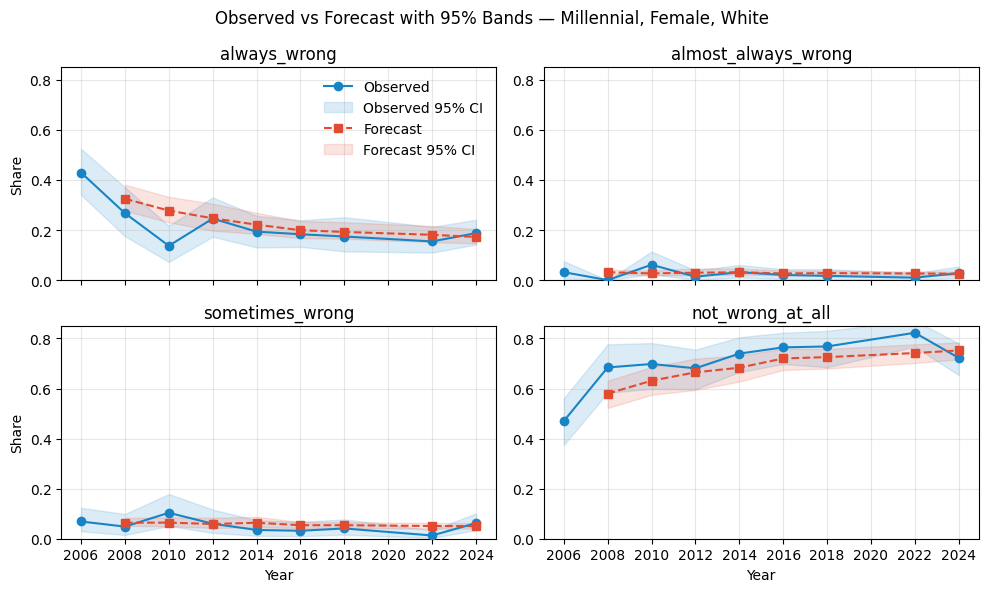

In [26]:
import matplotlib.pyplot as plt

# Pick a subgroup & its years (years where you have observed margins)
GEN, GENDER, RACE = "Millennial", "Female", "White"
g = (GEN, GENDER, RACE)
years = sorted({y for ((gg,y),_) in p_cs.items() if gg==g})

bands = forecast_with_bands_for_group(
    g, years, p_cs, effN_cs,
    alpha=0.5,   # ensemble weight
    B=300        # bootstrap size (200–1000 is typical)
)
plot_obs_vs_forecast_with_bands(g, years, bands)

/tmp/ipython-input-2128883689.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):
/tmp/ipython-input-2128883689.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.bfloat16):


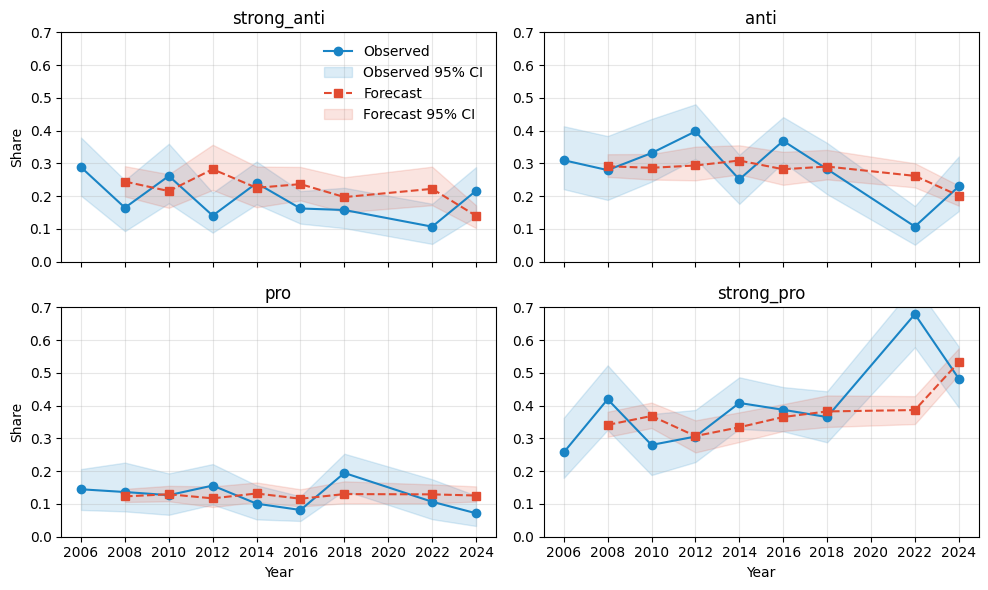

In [ ]:
import matplotlib.pyplot as plt

# Pick a subgroup & its years (years where you have observed margins)
GEN, GENDER, RACE = "Millennial", "Female", "White"
g = (GEN, GENDER, RACE)
years = sorted({y for ((gg,y),_) in p_cs.items() if gg==g})

bands = forecast_with_bands_for_group(
    g, years, p_cs, effN_cs,
    alpha=0.5,   # ensemble weight
    B=300        # bootstrap size (200–1000 is typical)
)
plot_obs_vs_forecast_with_bands(g, years, bands)

/tmp/ipython-input-1030515431.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=systems, showfliers=False)


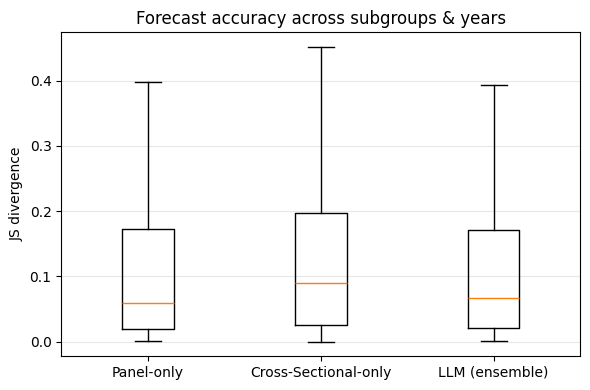

In [ ]:
# Build a long df with three systems: No-change, Panel-only, LLM (hat) — per (g, interval)
df_cmp = bt.copy()  # has JSD_hat, JSD_trans; compute No-change JSD if you saved it; else omit
rows = []
for _, r in df_cmp.iterrows():
    rows.append({"system":"Panel-only", "JSD": r["JSD_trans"], "year_t": r["year_t"], "year_t1": r["year_t1"]})
    rows.append({"system":"Cross-Sectional-only", "JSD": r["JSD_margin"], "year_t": r["year_t"], "year_t1": r["year_t1"]})
    rows.append({"system":"LLM (ensemble)", "JSD": r["JSD_hat"], "year_t": r["year_t"], "year_t1": r["year_t1"]})
cmp_long = pd.DataFrame(rows)

fig, ax = plt.subplots(figsize=(6,4))
systems = cmp_long["system"].unique()
data = [cmp_long[cmp_long["system"]==s]["JSD"].dropna().values for s in systems]
ax.boxplot(data, labels=systems, showfliers=False)
ax.set_ylabel("JS divergence")
ax.set_title("Forecast accuracy across subgroups & years")
ax.grid(axis="y", alpha=0.3)
plt.tight_layout(); plt.show()